# IMPORTS

In [1]:
from hvac_control.data import load_data
df = load_data("gaia_data.csv", header_names=None)
print(df.shape)
df.head()

(203206, 13)


,Unnamed: 0,T_ext,Solar_irrad,T_imp,T_ret,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow
0,2022-05-13 12:00:00+00:00,24.40,874.0,9.880005,10.869995,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0
1,2022-05-13 12:01:00+00:00,NaN,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0
2,2022-05-13 12:02:00+00:00,24.35,875.0,9.940002,10.750000,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0
3,2022-05-13 12:03:00+00:00,NaN,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0
4,2022-05-13 12:04:00+00:00,24.51,875.0,9.940002,10.899994,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0


# PREPROCESSING

In [6]:
from hvac_control.preprocessing import *

columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow', 'T_ret']

max_minutes=30
rows_to_skip=2
max_consecutive_nans=30
thresh_len=1000

dfs = first_preprocessing_step(df, max_minutes, rows_to_skip, max_consecutive_nans, thresh_len, columns)

Use all data from a cleaned dataframe

In [7]:
choosen_df=1
df_index = dfs[choosen_df]
print(df_index.shape)


(15862, 12)


Use only weekday data from a cleaned dataframe (weekends removed)

In [9]:
dfs_weekdays = remove_weekends(df_index)
df_concat = pd.concat(dfs_weekdays)
print(df_concat.shape)

(11542, 15)


# SOM

In [24]:
df_to_study = df_concat.copy()

## Remove non linear columns

In [25]:
#x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
#           'BC1_power', 'BC2_power', 'Refr1_power', 
#           'Refr2_power', 'BC1_flow', 'BC2_flow', 
#           'Refr1_flow', 'Refr2_flow']

x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'BC1_flow', 'BC2_flow', 
           'Refr2_flow']

y_column = ['T_ret']

all_columns = x_columns + y_column

## Split

In [26]:
from sklearn.model_selection import train_test_split

X=df_to_study[x_columns].to_numpy()
y=df_to_study[y_column].to_numpy()

# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (9233, 9)
y train shape:  (9233, 1)
x test shape:  (2309, 9)
x test shape:  (2309, 1)


## Scale

In [27]:
from hvac_control.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters

max_val = train_x.max()
min_val = train_x.min()
mu = train_x.mean(0)
s = train_x.std(0)

#train_x_norm = minmax_scaler_given_parameters(train_x, min_val, max_val)
#test_x_norm = minmax_scaler_given_parameters(test_x, min_val, max_val)

train_x_norm = std_scaler_given_parameters(train_x, mu, s)
test_x_norm = std_scaler_given_parameters(test_x, mu, s)

## Training

In [28]:
from hvac_control.som import SOM

model=SOM(som_grid_size=(20,20),
          max_distance=6,
          learning_rate_0=0.5,
          max_iter=100000,
          random_state=0,
          sigma_0=1, 
          sigma_decay=0.0005,
          learning_rate_decay=0.0005,
          methods={'init_som': 'uniform',
                  'bmu_distance': 'cityblock',
                  'compute_neighborhood': 'ceil',
                  'update_sigma_and_learning_rate': 'linear'}) 
model=model.fit(train_x_norm, epochs=8)
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

In [84]:
from minisom import MiniSom    
model2 = MiniSom(20, 20, 11, sigma=2, learning_rate=.5, 
                 neighborhood_function='gaussian', 
                 topology='rectangular',
                 activation_distance='euclidean', 
                 random_seed=None) 
model2.train(train_x_norm, 20000) 
som2=model2.get_weights()
som_dataset=som2.reshape(-1,som2.shape[2])

SOM data 2D: Total = 0.850181457723548 and per components = [0.7704204  0.07976106]
Train data 2D: Total = 0.8545276687051733 and per components = [0.76863491 0.08589276]


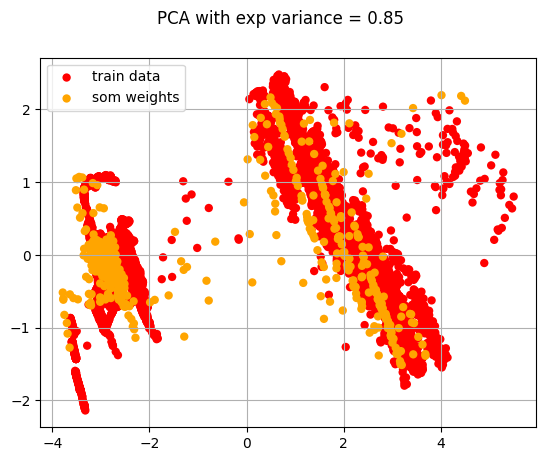

quantization error =  0.1758133787282236


In [29]:
from sklearn.decomposition import PCA
from hvac_control.som_metrics import SOMmetrics

# 2D vizualization
pca = PCA(n_components = 2)
pca_som = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"SOM data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca_train = pca.fit_transform(train_x_norm)
exp_variance_2d = pca.explained_variance_ratio_
print(f"Train data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(pca_train[:,0], pca_train[:,1], color="red", label="train data", edgecolors='none')
ax.scatter(pca_som[:,0], pca_som[:,1], color="orange", label="som weights", edgecolors='none')
ax.legend()
ax.grid(True)
fig.suptitle(f"PCA with exp variance = {round(np.sum(exp_variance_2d), 2)}")
plt.show()

metrics=SOMmetrics(model.som)
print('quantization error = ',metrics.quantization_error(train_x_norm, som))